<a href="https://colab.research.google.com/github/deniseiras/Artificial-Intelligence/blob/main/DENIS_Trabalho_8_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Uso de Rede Convolucional na classificação de extração e não extração de árvores na Floresta Amazônica.**

---
Este Notebook pode ser acesso em: https://colab.research.google.com/drive/1SyDcf9hrJVcQVVboTi84sin6lmJP_tPe?usp=sharing

---


 **Trabalho 8**

 **Grupo:**
- Daniel Merli Lamosa
- Denis Magalhaes De Almeida Eiras
- Luiz Gustavo Miranda Pinto

# Imports e download dos arquivos

In [ ]:
import numpy as np
np.random.seed(1337) # for reproducibility

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, concatenate, Reshape, Input, InputLayer, Softmax, \
     Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Activation, BatchNormalization, ReLU
from IPython import display


from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import train_test_split

In [ ]:
#Download
!wget https://www.dropbox.com/sh/j7fthly8b3eugpf/AABOsZgtxFp-vZCIv-aFNNMka/CSKS3_20180605_deGrandi.tif
!wget https://www.dropbox.com/sh/j7fthly8b3eugpf/AADGUDQxKpZeKrg5Vz6jLd1Va/CSKS3_20181008_deGrandi.tif
!wget https://www.dropbox.com/sh/j7fthly8b3eugpf/AAChhVFe9eXAdLyNgwKWJJlfa/binaria_jun_out_treinamento.tiff


--2021-10-27 20:02:30--  https://www.dropbox.com/sh/j7fthly8b3eugpf/AABOsZgtxFp-vZCIv-aFNNMka/CSKS3_20180605_deGrandi.tif
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/j7fthly8b3eugpf/AABOsZgtxFp-vZCIv-aFNNMka/CSKS3_20180605_deGrandi.tif [following]
--2021-10-27 20:02:31--  https://www.dropbox.com/sh/raw/j7fthly8b3eugpf/AABOsZgtxFp-vZCIv-aFNNMka/CSKS3_20180605_deGrandi.tif
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1f4f3cdc2eb3d7e5a8fba78ec1.dl.dropboxusercontent.com/cd/0/inline/BY2QwBjnrZy7gJXRMC_uasgYcYYEM44w12Tigg7dZ8VQk-57qxSVapPmKKScKDniJ2lL-QIzkVNdIm0gUNoE0HxsmGy7ldF-6PhOfgikTXQw6LpJMtadMY_vR1cEjke6Ugg6f1HIt2jACIV8hnywN8OY/file# [following]
--2021-10-27 20:02:31--  https://uc1f4f3cdc2eb3d7e5a8fba78ec1

# Manipulando os arquivos originais para criação do dataset

## Abrindo arquivos

In [ ]:
image01  = Image.open('CSKS3_20180605_deGrandi.tif')
image02  = Image.open('CSKS3_20181008_deGrandi.tif')
imageaws = Image.open('binaria_jun_out_treinamento.tiff')

CSKS3_20180605_deGrandi.tif 1
img01_array min/max 2.1113915e-06 4.1995244
CSKS3_20181008_deGrandi.tif 1
img02_array min/max 1e-06 4.5447755
binaria_jun_out_treinamento.tif 1
imgaws_array min/max 0.0 1.0
[[0.16276912 0.48111072 0.24430814 ... 0.0888463  0.2916893  0.26538822]
 [0.03183116 0.1401448  0.22177969 ... 0.05881154 0.05503323 0.11603761]
 [0.04591234 0.07835454 0.08398385 ... 0.28729245 0.11279596 0.09191492]
 ...
 [0.10597789 0.18665195 0.13238536 ... 0.06712087 0.05983581 0.02139713]
 [0.02011808 0.07541181 0.21288396 ... 0.02777107 0.05104324 0.14599472]
 [0.03990528 0.03722366 0.13728067 ... 0.00799859 0.1206003  0.5438251 ]] 

[[0.19694392 0.86797553 0.47325194 ... 0.07075717 0.19167703 0.1430065 ]
 [0.03487642 0.19378284 0.42729068 ... 0.04718694 0.0480902  0.08733546]
 [0.03982428 0.09312338 0.13166252 ... 0.29015473 0.09612054 0.07111427]
 ...
 [0.09054349 0.17914921 0.13248983 ... 0.08744562 0.06750613 0.02609027]
 [0.0140892  0.05537649 0.18519387 ... 0.0363268  0.05

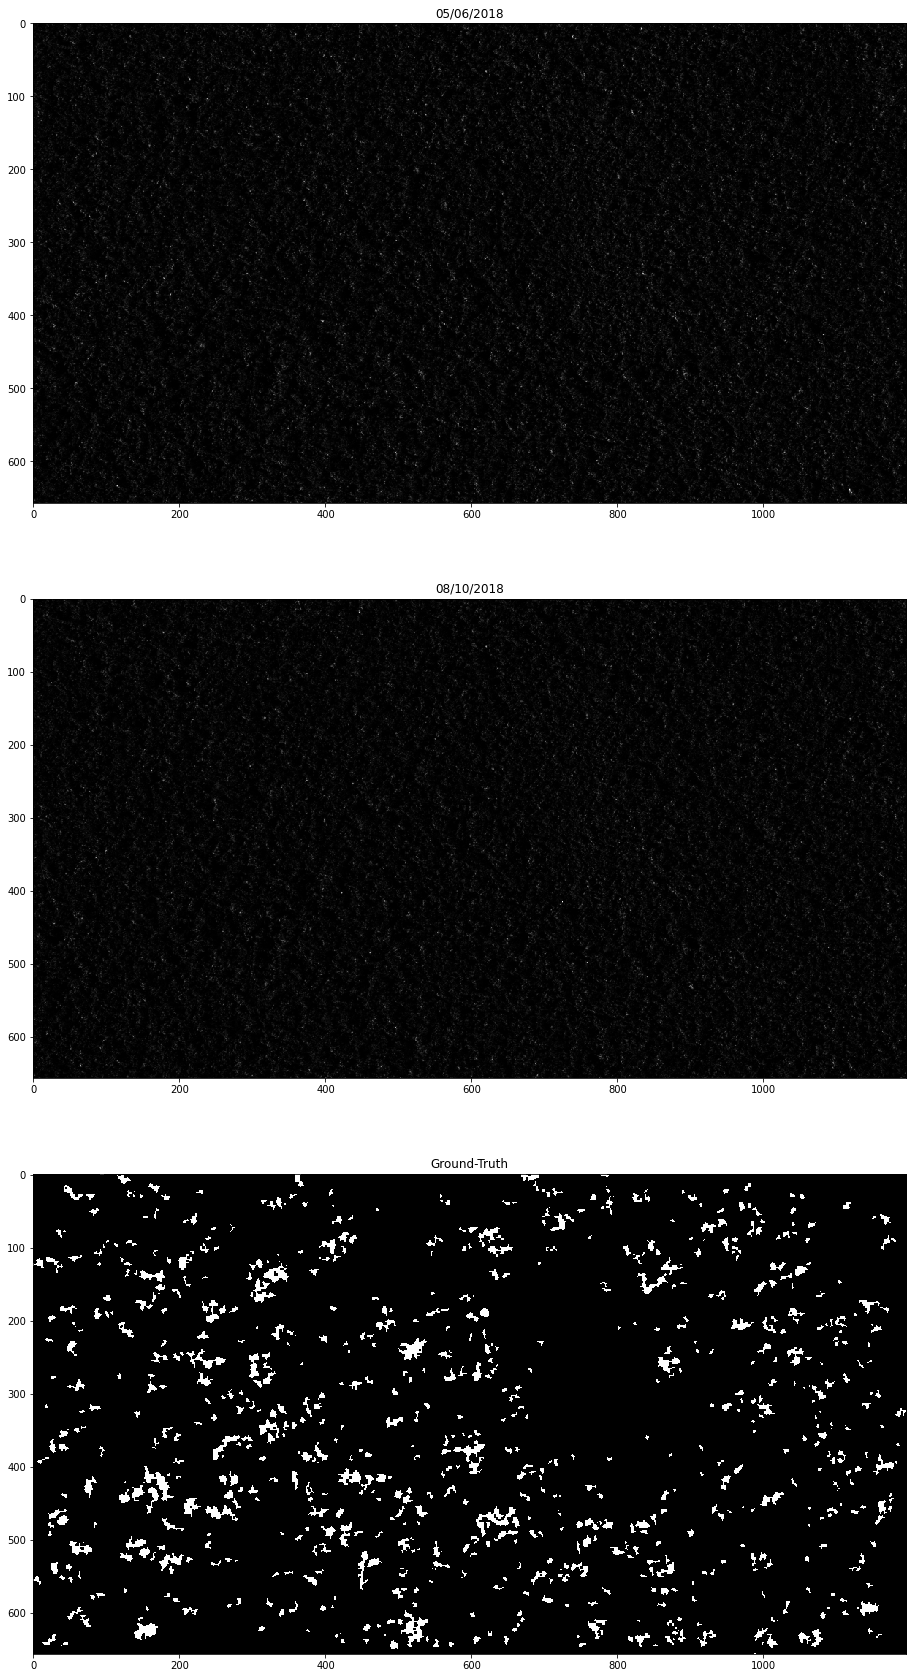

In [ ]:
from osgeo import gdal

dataset = gdal.Open('CSKS3_20180605_deGrandi.tif', gdal.GA_ReadOnly)
print('CSKS3_20180605_deGrandi.tif', dataset.RasterCount)
band = dataset.GetRasterBand(1)
img01_array = np.array(band.ReadAsArray())
print('img01_array min/max', img01_array.min(), img01_array.max())


dataset = gdal.Open('CSKS3_20181008_deGrandi.tif', gdal.GA_ReadOnly)
print('CSKS3_20181008_deGrandi.tif', dataset.RasterCount)
band = dataset.GetRasterBand(1)
img02_array = np.array(band.ReadAsArray())
print('img02_array min/max', img02_array.min(), img02_array.max())

dataset = gdal.Open('binaria_jun_out_treinamento.tiff', gdal.GA_ReadOnly)
print('binaria_jun_out_treinamento.tif', dataset.RasterCount)
band = dataset.GetRasterBand(1)
imgaws_array = np.array(band.ReadAsArray()).astype('float64')
print('imgaws_array min/max', imgaws_array.min(), imgaws_array.max())

img01_plot = img01_array*255./img01_array.max() 
# img01_array *= 1./img01_array.max() 
print(img01_array,'\n')

img02_plot = img02_array*255./img02_array.max() 
# img02_array *= 1./img02_array.max() 
print(img02_array,'\n')

imgaws_plot = imgaws_array*255.0/imgaws_array.max() 
# imgaws_array *= 1./imgaws_array.max() 
print(imgaws_array,'\n')

fig = plt.figure(figsize = (30,30))

ax1 = fig.add_subplot(3,1,1)
ax1.set_title('05/06/2018')
ax1.imshow(img01_plot, interpolation='none',cmap='Greys_r')

ax2 = fig.add_subplot(3,1,2)
ax2.set_title('08/10/2018')
ax2.imshow(img02_plot, interpolation='none',cmap='Greys_r')

ax3 = fig.add_subplot(3,1,3)
ax3.set_title('Ground-Truth')
ax3.imshow(imgaws_plot, interpolation='none',cmap='Greys_r')



## Funções criadas para gerar os casos de treinamento e teste

In [ ]:
# Split each array in [block_x, block_y] size
# Last line and column blocks made by last block_x, block_y elements
def split(arr, block_x, block_y):
  dim_x = arr.shape[0]
  dim_y = arr.shape[1]
  array_tiles = []
  for x in range(0,dim_x, block_x):
    for y in range(0,dim_y, block_y):
      array_tiles.append(arr[x:x + block_x, y:y+block_y])
    array_tiles.append(arr[x:x + block_x, -block_y:]) # last column
  for y in range(0,dim_y, block_y):  # Last line
    array_tiles.append(arr[-block_x:, y:y+block_y])
  array_tiles.append(arr[-block_x:, -block_y:])
    
  array_tiles = np.array(array_tiles, dtype='object')
  return array_tiles

def split_train_and_test(first_image, second_image, aws_image, block_x, block_y=None, stride=None, tax=0.1, seed=42):
  if(first_image.size != second_image.size and first_image.size != aws_image.size):
    print("Imagens aren\'t the same size")
  else:
    
    if(block_y == None):
      block_y = block_x

    # Split images
    fi_tiles = split(first_image, block_x, block_y)
    si_tiles = split(second_image, block_x, block_y)
    ai_tiles = split(aws_image, block_x, block_y)

    # / 2
    fi_train, fi_test, si_train, si_test = train_test_split(fi_tiles, si_tiles, test_size=tax/2, random_state=seed)
    ai_train, ai_test = train_test_split(ai_tiles, test_size=tax, random_state=seed)
    
    return fi_train, fi_test, si_train, si_test, ai_train, ai_test


def normalization(imgs):
  
  for k in range(imgs.size):
    min = imgs[k].min()
    max = imgs[k].max()
    imgs[k] = (imgs[k] - min)/(max-min)
  return imgs



# Encoder decoder

In [ ]:
# https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/



# TODO
# Deconv2d


#  out_shape   ver se input_shape nao deveria ser inp_shape
def v1(img_size_xy, code_size=None):
  
  inp_bands = 2
  out_bands = 1

  inp_shape = (img_size_xy, img_size_xy, inp_bands)
  out_shape = (img_size_xy, img_size_xy)

  encoder = Sequential()
  encoder.add(InputLayer(inp_shape))
  # encoder.add(Conv2D(64, 3, padding='same', input_shape=out_shape))
  encoder.add(Conv2D(64, 3, padding='same'))
  encoder.add(LeakyReLU(alpha=0.1))
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.25))

  encoder.add(Conv2D(32, 3, padding='same'))
  encoder.add(LeakyReLU(alpha=0.1))
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.25))

  encoder.add(Conv2D(16, 3, padding='same'))
  encoder.add(LeakyReLU(alpha=0.1))
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.4))
  
  # com code_size
  # encoder.add(Flatten())
  # encoder.add(Dense(code_size))
  
  # decoder
  decoder = Sequential()

  # com code_size
  # decoder.add(InputLayer((code_size,)))
  # decoder.add(Dense(np.prod(out_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
  
  # sem code_size
  decoder.add(InputLayer(encoder.output_shape[1:]))

  decoder.add(UpSampling2D(2))
  decoder.add(LeakyReLU(alpha=0.1))
  decoder.add(Dropout(0.4))

  decoder.add(UpSampling2D(2))
  decoder.add(Conv2D(32, 3, padding='same'))
  decoder.add(LeakyReLU(alpha=0.1))
  decoder.add(Dropout(0.25))

  decoder.add(UpSampling2D(2))
  decoder.add(Conv2D(64, 3, padding='same'))
  decoder.add(LeakyReLU(alpha=0.1))
  decoder.add(Dropout(0.25))

  decoder.add(Conv2D(1, 3, padding='same'))
  decoder.add(Reshape(out_shape))
  print('decoder.input_shape = ', decoder.input_shape)
  print('decoder.output_shape = ', decoder.output_shape)

  inp = Input(inp_shape)
  code = encoder(inp)
  reconstruction = decoder(code)
  autoencoder = Model(inp,reconstruction)

  autoencoder.compile(optimizer='adamax', loss='mse', metrics=['mse', 'mae'])
  print(autoencoder.summary())

  return autoencoder, encoder, decoder


#  out_shape   ver se input_shape nao deveria ser inp_shape
def v1_relu(img_size_xy, code_size=None):
  
  inp_bands = 2
  out_bands = 1

  inp_shape = (img_size_xy, img_size_xy, inp_bands)
  out_shape = (img_size_xy, img_size_xy)

  encoder = Sequential()
  encoder.add(InputLayer(inp_shape))
  # encoder.add(Conv2D(64, 3, padding='same', input_shape=out_shape))
  encoder.add(Conv2D(64, 3, activation='relu', padding='same'))
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.25))

  encoder.add(Conv2D(32, 3, activation='relu', padding='same'))
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.25))

  encoder.add(Conv2D(16, 3, activation='relu', padding='same'))
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.4))
  
  # com code_size
  # encoder.add(Flatten())
  # encoder.add(Dense(code_size))
  
  # decoder
  decoder = Sequential()

  # com code_size
  # decoder.add(InputLayer((code_size,)))
  # decoder.add(Dense(np.prod(out_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
  
  # sem code_size
  decoder.add(InputLayer(encoder.output_shape[1:]))

  decoder.add(UpSampling2D(2))
  decoder.add(ReLU())
  decoder.add(Dropout(0.4))

  decoder.add(UpSampling2D(2))
  decoder.add(Conv2D(32, 3, activation='relu', padding='same'))
  decoder.add(Dropout(0.25))

  decoder.add(UpSampling2D(2))
  decoder.add(Conv2D(64, 3, activation='relu', padding='same'))
  decoder.add(Dropout(0.25))

  decoder.add(Conv2D(1, 3, padding='same'))
  decoder.add(Reshape(out_shape))
  print('decoder.input_shape = ', decoder.input_shape)
  print('decoder.output_shape = ', decoder.output_shape)

  inp = Input(inp_shape)
  code = encoder(inp)
  reconstruction = decoder(code)
  autoencoder = Model(inp,reconstruction)

  autoencoder.compile(optimizer='adamax', loss='mse', metrics=['mse', 'mae'])
  print(autoencoder.summary())

  return autoencoder, encoder, decoder


#  out_shape   ver se input_shape nao deveria ser inp_shape
def v1_relu_norm(img_size_xy, code_size=None):
  
  inp_bands = 2
  out_bands = 1

  inp_shape = (img_size_xy, img_size_xy, inp_bands)
  out_shape = (img_size_xy, img_size_xy)

  encoder = Sequential()
  encoder.add(InputLayer(inp_shape))
  # encoder.add(Conv2D(64, 3, padding='same', input_shape=out_shape))
  encoder.add(Conv2D(64, 3, activation='relu', padding='same'))
  encoder.add(BatchNormalization())
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.25))

  encoder.add(Conv2D(32, 3, activation='relu', padding='same'))
  encoder.add(BatchNormalization())
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.25))

  encoder.add(Conv2D(16, 3, activation='relu', padding='same'))
  encoder.add(BatchNormalization())
  encoder.add(MaxPooling2D(pool_size=2,padding='same'))
  encoder.add(Dropout(0.4))
  
  # com code_size
  # encoder.add(Flatten())
  # encoder.add(Dense(code_size))
  
  # decoder
  decoder = Sequential()

  # com code_size
  # decoder.add(InputLayer((code_size,)))
  # decoder.add(Dense(np.prod(out_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
  
  # sem code_size
  decoder.add(InputLayer(encoder.output_shape[1:]))

  decoder.add(UpSampling2D(2))
  decoder.add(ReLU())
  decoder.add(Dropout(0.4))

  decoder.add(UpSampling2D(2))
  decoder.add(Conv2D(32, 3, activation='relu', padding='same'))
  encoder.add(BatchNormalization())
  decoder.add(Dropout(0.25))

  decoder.add(UpSampling2D(2))
  decoder.add(Conv2D(64, 3, activation='relu', padding='same'))
  encoder.add(BatchNormalization())
  decoder.add(Dropout(0.25))

  decoder.add(Conv2D(1, 3, padding='same'))
  encoder.add(BatchNormalization())
  decoder.add(Reshape(out_shape))
  print('decoder.input_shape = ', decoder.input_shape)
  print('decoder.output_shape = ', decoder.output_shape)

  inp = Input(inp_shape)
  code = encoder(inp)
  reconstruction = decoder(code)
  autoencoder = Model(inp,reconstruction)

  autoencoder.compile(optimizer='adamax', loss='mse', metrics=['mse', 'mae'])
  print(autoencoder.summary())

  return autoencoder, encoder, decoder


def v2(img_size_xy, code_size=None):
  
  inp_bands = 2
  out_bands = 1

  inp_shape = (img_size_xy, img_size_xy, inp_bands)
  out_shape = (img_size_xy, img_size_xy)

  pad = 1

  encoder = Sequential()
  encoder.add(InputLayer(inp_shape))
  print('encoder.input_shape = ', encoder.input_shape)
  print('encoder.output_shape = ', encoder.output_shape)  
  # encoder.add(ZeroPadding2D(padding=(pad, pad)))
  encoder.add(Conv2D(64, 3, input_shape=out_shape, padding='same'))
  encoder.add(BatchNormalization())
  encoder.add(MaxPooling2D(pool_size=2))
  print('encoder.input_shape = ', encoder.input_shape)
  print('encoder.output_shape = ', encoder.output_shape)
  
  # encoder.add(ZeroPadding2D(padding=(pad, pad)))
  encoder.add(Conv2D(128, 3, padding='same'))
  encoder.add(BatchNormalization())
  encoder.add(Activation('relu'))
  encoder.add(MaxPooling2D(pool_size=2))
  print('encoder.input_shape = ', encoder.input_shape)
  print('encoder.output_shape = ', encoder.output_shape)

  # encoder.add(ZeroPadding2D(padding=(pad, pad)))
  encoder.add(Conv2D(512, 3, padding='same'))
  encoder.add(BatchNormalization())
  encoder.add(Activation('relu'))
  encoder.add(MaxPooling2D(pool_size=2))
  print('encoder.input_shape = ', encoder.input_shape)
  print('encoder.output_shape = ', encoder.output_shape)


  # decoder
  decoder = Sequential()

  # sem code_size
  decoder.add(InputLayer(encoder.output_shape[1:]))
  print('encoder.input_shape = ', encoder.input_shape)
  print('encoder.output_shape = ', encoder.output_shape)

  # decoder.add(ZeroPadding2D(padding=(pad, pad)))
  decoder.add(Conv2D(512, 3, padding='same'))
  decoder.add(BatchNormalization())
  print('encoder.input_shape = ', encoder.input_shape)
  print('encoder.output_shape = ', encoder.output_shape)


  decoder.add(UpSampling2D(2))
  # decoder.add(ZeroPadding2D(padding=(pad, pad)))
  decoder.add(Conv2D(256, 3, padding='same'))
  decoder.add(BatchNormalization())
  print('decoder.input_shape = ', decoder.input_shape)
  print('decoder.output_shape = ', decoder.output_shape)


  decoder.add(UpSampling2D(2))
  # decoder.add(ZeroPadding2D(padding=(pad, pad)))
  decoder.add(Conv2D(128, 3, padding='same'))
  decoder.add(BatchNormalization())
  print('decoder.input_shape = ', decoder.input_shape)
  print('decoder.output_shape = ', decoder.output_shape)


  decoder.add(UpSampling2D(2))
  # decoder.add(ZeroPadding2D(padding=(pad, pad)))
  decoder.add(Conv2D(64, 3, padding='same'))
  decoder.add(BatchNormalization())
  print('decoder.input_shape = ', decoder.input_shape)
  print('decoder.output_shape = ', decoder.output_shape)

  decoder.add(Conv2D(1, 3, padding='same'))
  decoder.add(Reshape(out_shape))
  print('decoder.input_shape = ', decoder.input_shape)
  print('decoder.output_shape = ', decoder.output_shape)

  inp = Input(inp_shape)
  code = encoder(inp)
  reconstruction = decoder(code)
  autoencoder = Model(inp,reconstruction)

  # autoencoder.compile(loss="binary_crossentropy", optimizer='rmsprop',
  #                 metrics=['binary_accuracy'])

  autoencoder.compile(optimizer='adamax', loss='mse', metrics=['mse', 'mae'])
  print(autoencoder.summary())

  return autoencoder, encoder, decoder

# def build_autoencoder(inp_img_shape, out_img_shape, code_size):
#     # The encoder
#     encoder = Sequential()
#     encoder.add(InputLayer(inp_img_shape))
#     encoder.add(Flatten())
#     encoder.add(Dense(code_size))

#     # The decoder
#     decoder = Sequential()
#     decoder.add(InputLayer((code_size,)))
#     decoder.add(Dense(np.prod(out_img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
#     decoder.add(Reshape(out_img_shape))

#     return encoder, decoder

# Treinamento

Testar

- img_size_xy
- usar batchnorm depois da conv-   ruim

- usar codigo
 

In [ ]:
def run_exp(img_size_xy, autoencoder, encoder, decoder, p_epochs=10000, p_batchsize=128, p_valsplit=0.2):
  batch_size = p_batchsize
  val_split = p_valsplit
  epochs = p_epochs

  fi_train, fi_test, si_train, si_test, ai_train, ai_test = split_train_and_test(img01_array, img02_array, imgaws_array, img_size_xy)

  fi_train = normalization(fi_train)
  si_train = normalization(si_train)
  fi_test  = normalization(fi_test)
  si_test  = normalization(si_test)
  ai_train = normalization(ai_train)
  ai_test  = normalization(ai_test)

  ns_train = len(fi_train)
  ns_test = len(fi_test)

  X_train  = np.empty((ns_train, img_size_xy, img_size_xy, inp_bands))
  X_test  = np.empty((ns_test, img_size_xy, img_size_xy, inp_bands))
  y_train = np.empty((ns_train, img_size_xy, img_size_xy))
  y_test = np.empty((ns_test, img_size_xy, img_size_xy))

  ns_train = -1
  for fitrain, sitrain, aitrain in zip(fi_train, si_train, ai_train):
    ns_train += 1
    if fitrain.shape[0] != img_size_xy or fitrain.shape[1] != img_size_xy or \
      aitrain.shape[0] != img_size_xy or aitrain.shape[1] != img_size_xy:
      # print('pulando fitrain, aitrain =', fitrain.shape, aitrain.shape)
      continue
    img_inp = np.empty((img_size_xy, img_size_xy, inp_bands))
    img_inp[:,:,0] = fitrain
    img_inp[:,:,1] = sitrain
    X_train[ns_train, :, :, :] = img_inp
    y_train[ns_train, :, :] = aitrain
  X_train = X_train[0:ns_train+1, :, :, :]
  y_train = y_train[0:ns_train+1, :, :]

  ns_test = -1
  for fitest, sitest, aitest in zip(fi_test, si_test, ai_test):
    ns_test +=1
    if fitest.shape[0] != img_size_xy or fitest.shape[1] != img_size_xy:
      # print('pulando fitest =', fitest.shape)
      continue
    img_inp = np.empty((img_size_xy, img_size_xy, inp_bands))
    img_inp[:,:,0] = fitest
    img_inp[:,:,1] = sitest
    X_test[ns_test, :, :, :] = img_inp
    y_test[ns_test, :, :] = aitest
  X_test = X_test[0:ns_test+1, :, :, :]
  y_test = y_test[0:ns_test+1, :, :]


  # print('X_train.shape', X_train.shape)
  # print('X_train', X_train[0:10])
  # print('X_test.shape', X_test.shape)
  # print('X_test', X_test[0:2])
  # print('y_train.shape', y_train.shape)
  # print('y_train', y_train[0:2])
  # print('y_test.shape', y_test.shape)
  # print('y_test.shape', y_test[0:2])

  # history = autoencoder.fit(x=X_train, y=y_train, epochs=nepochs, validation_data=(X_test, y_test))
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100)

  # TODO valitadion_split -> depois validar test 
  history = autoencoder.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split, callbacks=[callback], use_multiprocessing=True)
  # history = autoencoder.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[callback], use_multiprocessing=True)

  loss_metric_train = autoencoder.evaluate(X_train, y_train, verbose=0, batch_size=batch_size, use_multiprocessing=True)
  print( 'TRAINING set.Loss = {} , MSE = {}, MAE = {}'.format(loss_metric_train[0], loss_metric_train[1], loss_metric_train[2]))
  loss_metric_test = autoencoder.evaluate(X_test, y_test, verbose=0, batch_size=batch_size, use_multiprocessing=True)
  print( 'TEST set.    Loss = {} , MSE = {}, MAE = {}'.format(loss_metric_test[0], loss_metric_test[1], loss_metric_test[2]))

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(history.history['loss'], label="Loss Treino")
  plt.plot(history.history['val_loss'], label="Loss Validação")
  plt.plot(epochs+1, loss_metric_test[0], 'xr', markersize=5, label="Loss Test")
  plt.legend()
  plt.show()

  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.plot(history.history['val_mse'], label="MSE Treino")
  plt.plot(history.history['val_mae'], label="MAE Treino")

  plt.plot(epochs+1, loss_metric_test[1], 'xb', markersize=5, label="MSE Test")
  plt.plot(epochs+1, loss_metric_test[2], 'xr', markersize=5, label="MAE Test")
  plt.legend()
  plt.show()


  num_samples_plot = 20
  fig = plt.figure(figsize = (15,40))
  for ns in range(num_samples_plot):

    # TODOOOOOO
    x_img_test = X_test[ns, :, :, :]
    y_img_test = y_test[ns, :, :]
    
    # x_img_test = X_train[ns, :, :, :]
    # y_img_test = y_train[ns, :, :]


    # img_inp[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(x_img_test[None])[0]
    reco = decoder.predict(code[None])[0]

    cols = 2
    # banda 1
    ax1 = fig.add_subplot(num_samples_plot, cols,(ns*cols)+1)
    plt.title('Bin target')
    ax1.imshow(y_img_test, interpolation='none',cmap='Greys_r')  

    # # code
    # ax1 = fig.add_subplot(num_samples_plot, cols,(ns*cols)+4)
    # plt.title("Code")
    # ax1.imshow(code.reshape([code.shape[-1]//2,-1]))

    # image decoded from original
    ax1 = fig.add_subplot(num_samples_plot, cols,(ns*cols)+2)
    plt.title('bin predict')
    ax1.imshow(reco, interpolation='none' ,cmap='Greys_r')

  # plt.show()






## Teste v1

decoder.input_shape =  (None, 4, 4, 16)
decoder.output_shape =  (None, 32, 32)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 32, 32, 2)]       0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 4, 4, 16)          24304     
_________________________________________________________________
sequential_17 (Sequential)   (None, 32, 32)            23713     
Total params: 48,017
Trainable params: 48,017
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10000
5/5 [==============================] - 1s 54ms/step - loss: 0.0477 - mse: 0.0477 - mae: 0.0860 - val_loss: 0.0523 - val_mse: 0.0523 - val_mae: 0.0672
Epoch 2/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.0818 - val_loss: 0.0517 - val_mse

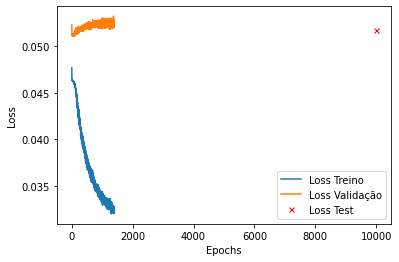

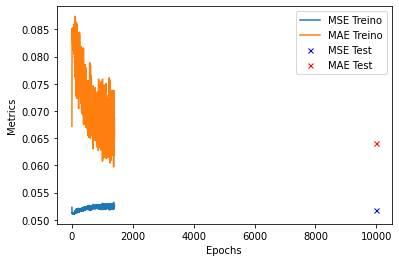

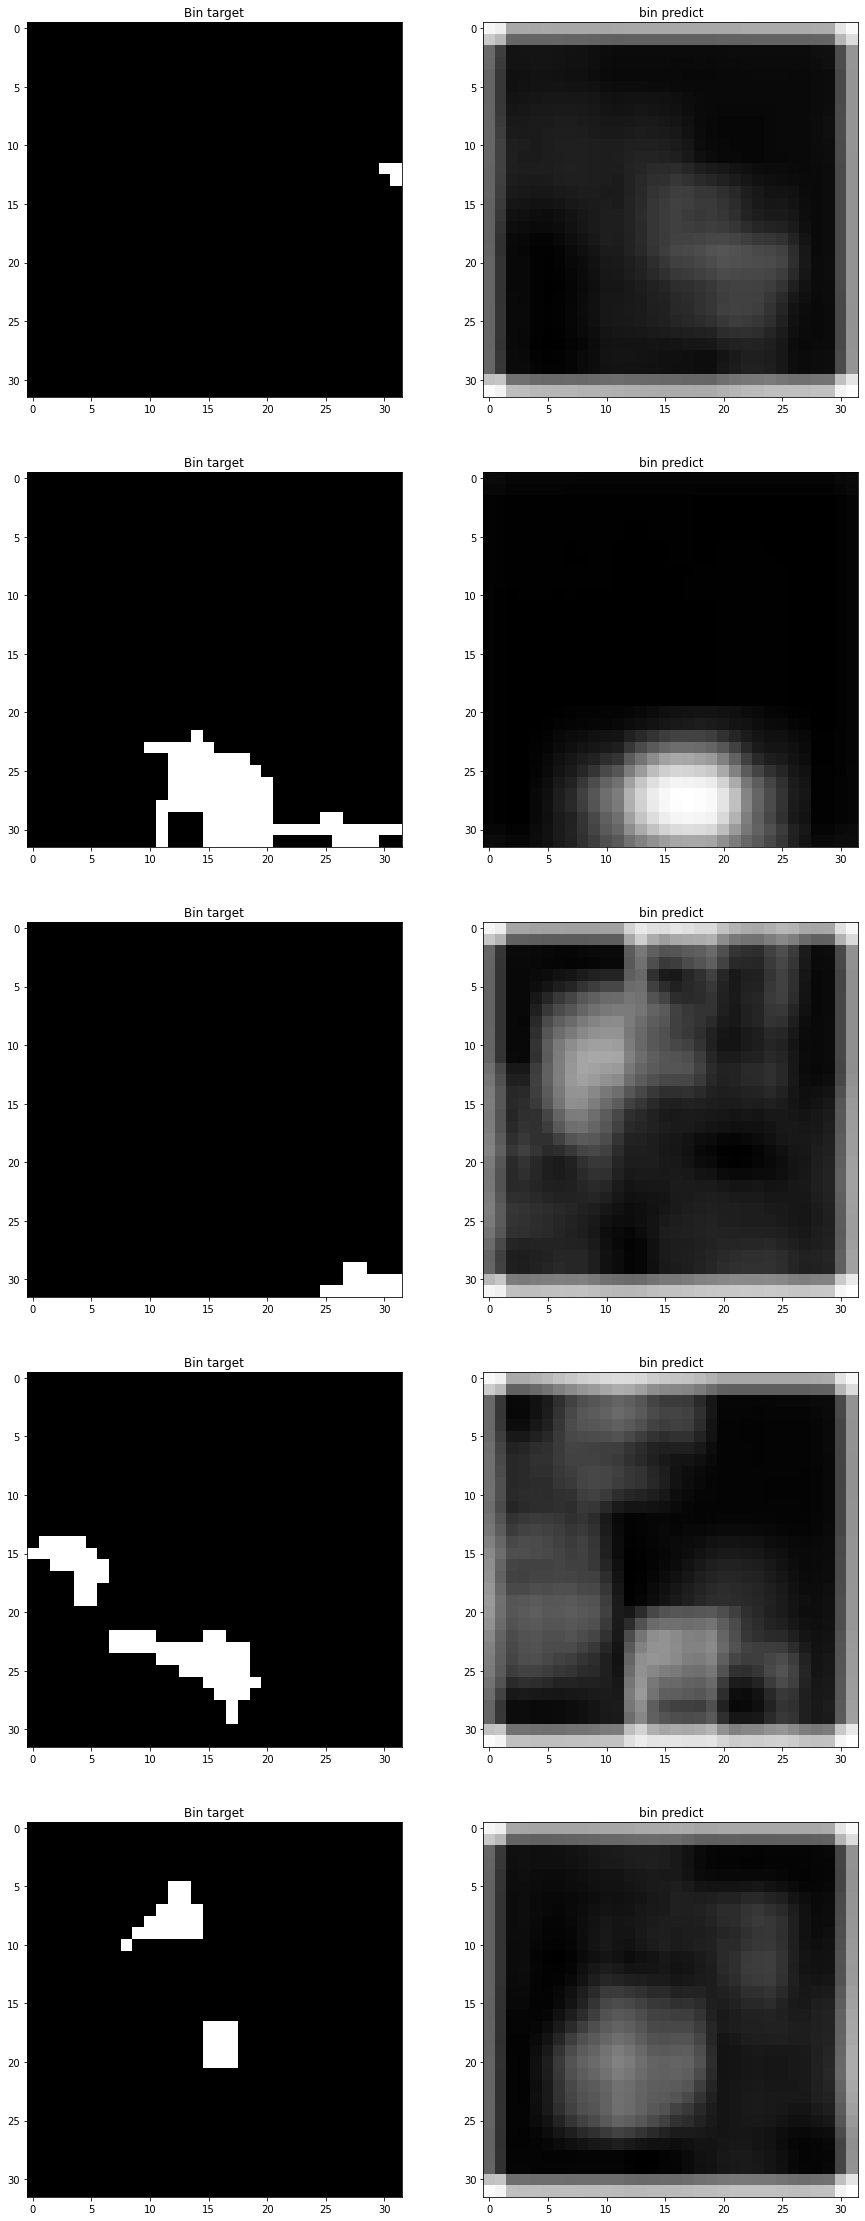

In [ ]:
img_size_xy = 32
inp_bands = 2
autoencoder, encoder, decoder = v1(img_size_xy, inp_bands)

run_exp(img_size_xy, autoencoder, encoder, decoder)


## Teste v1_relu

decoder.input_shape =  (None, 4, 4, 16)
decoder.output_shape =  (None, 32, 32)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 32, 32, 2)]       0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 4, 4, 16)          24304     
_________________________________________________________________
sequential_19 (Sequential)   (None, 32, 32)            23713     
Total params: 48,017
Trainable params: 48,017
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10000
5/5 [==============================] - 1s 78ms/step - loss: 0.0491 - mse: 0.0491 - mae: 0.0746 - val_loss: 0.0532 - val_mse: 0.0532 - val_mae: 0.0585
Epoch 2/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.0472 - mse: 0.0472 - mae: 0.0708 - val_loss: 0.0518 - val_mse

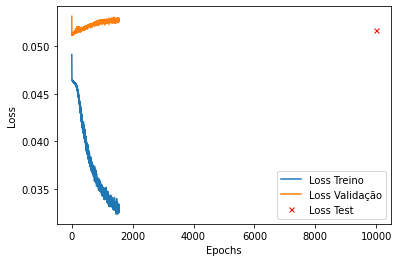

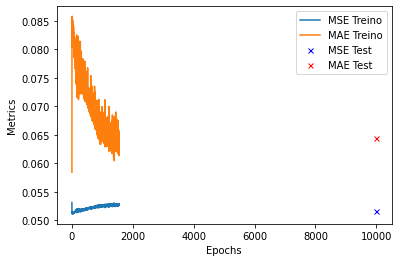

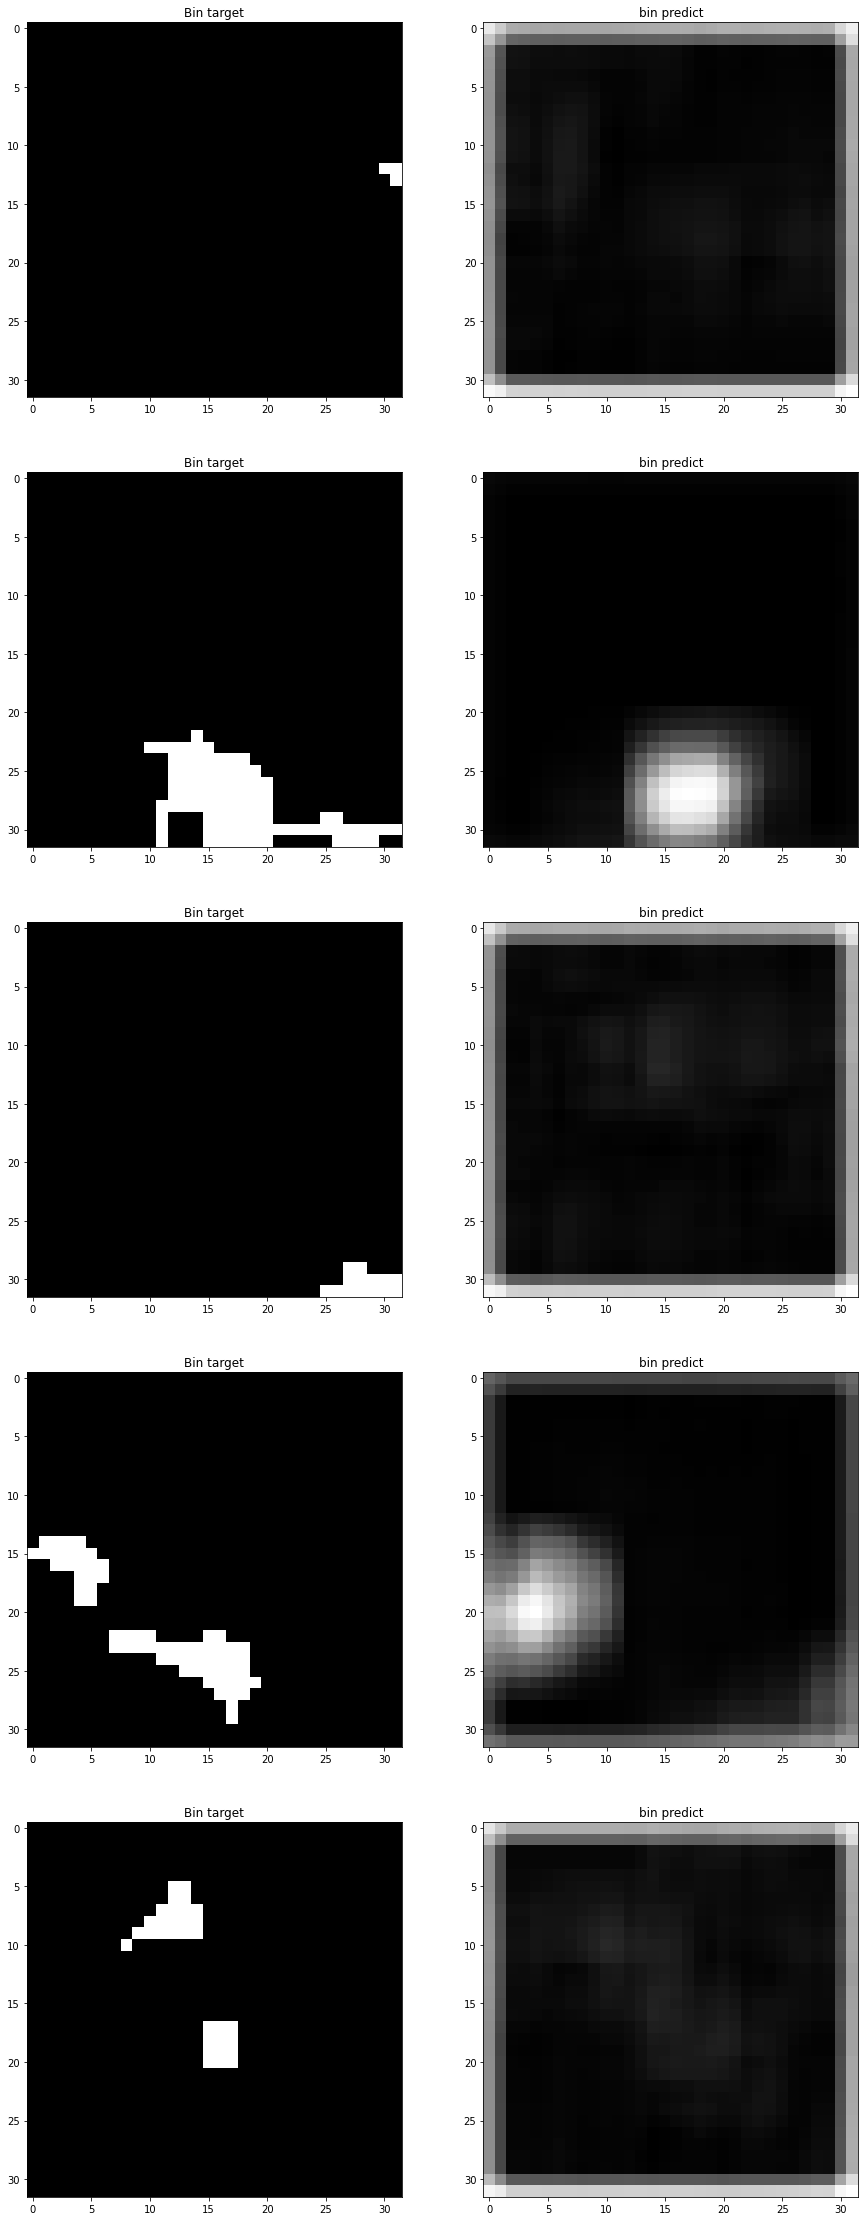

In [ ]:
img_size_xy = 32
inp_bands = 2
autoencoder, encoder, decoder = v1_relu(img_size_xy, inp_bands)

run_exp(img_size_xy, autoencoder, encoder, decoder)


## Teste v1_relu_norm

decoder.input_shape =  (None, 4, 4, 16)
decoder.output_shape =  (None, 32, 32)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 32, 32, 2)]       0         
_________________________________________________________________
sequential_21 (Sequential)   (None, 4, 4, 16)          24944     
_________________________________________________________________
sequential_22 (Sequential)   (None, 32, 32)            23713     
Total params: 48,657
Trainable params: 48,337
Non-trainable params: 320
_________________________________________________________________
None
Epoch 1/10000
5/5 [==============================] - 1s 68ms/step - loss: 55.3719 - mse: 55.3719 - mae: 0.5568 - val_loss: 0.0526 - val_mse: 0.0526 - val_mae: 0.0646
Epoch 2/10000
5/5 [==============================] - 0s 17ms/step - loss: 55.1755 - mse: 55.1755 - mae: 0.6096 - val_loss: 0.0524 - 

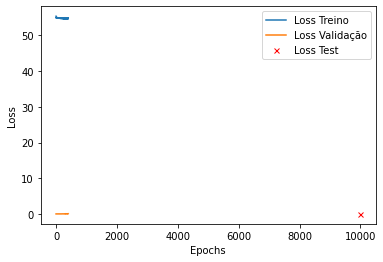

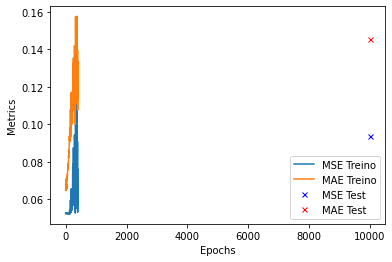

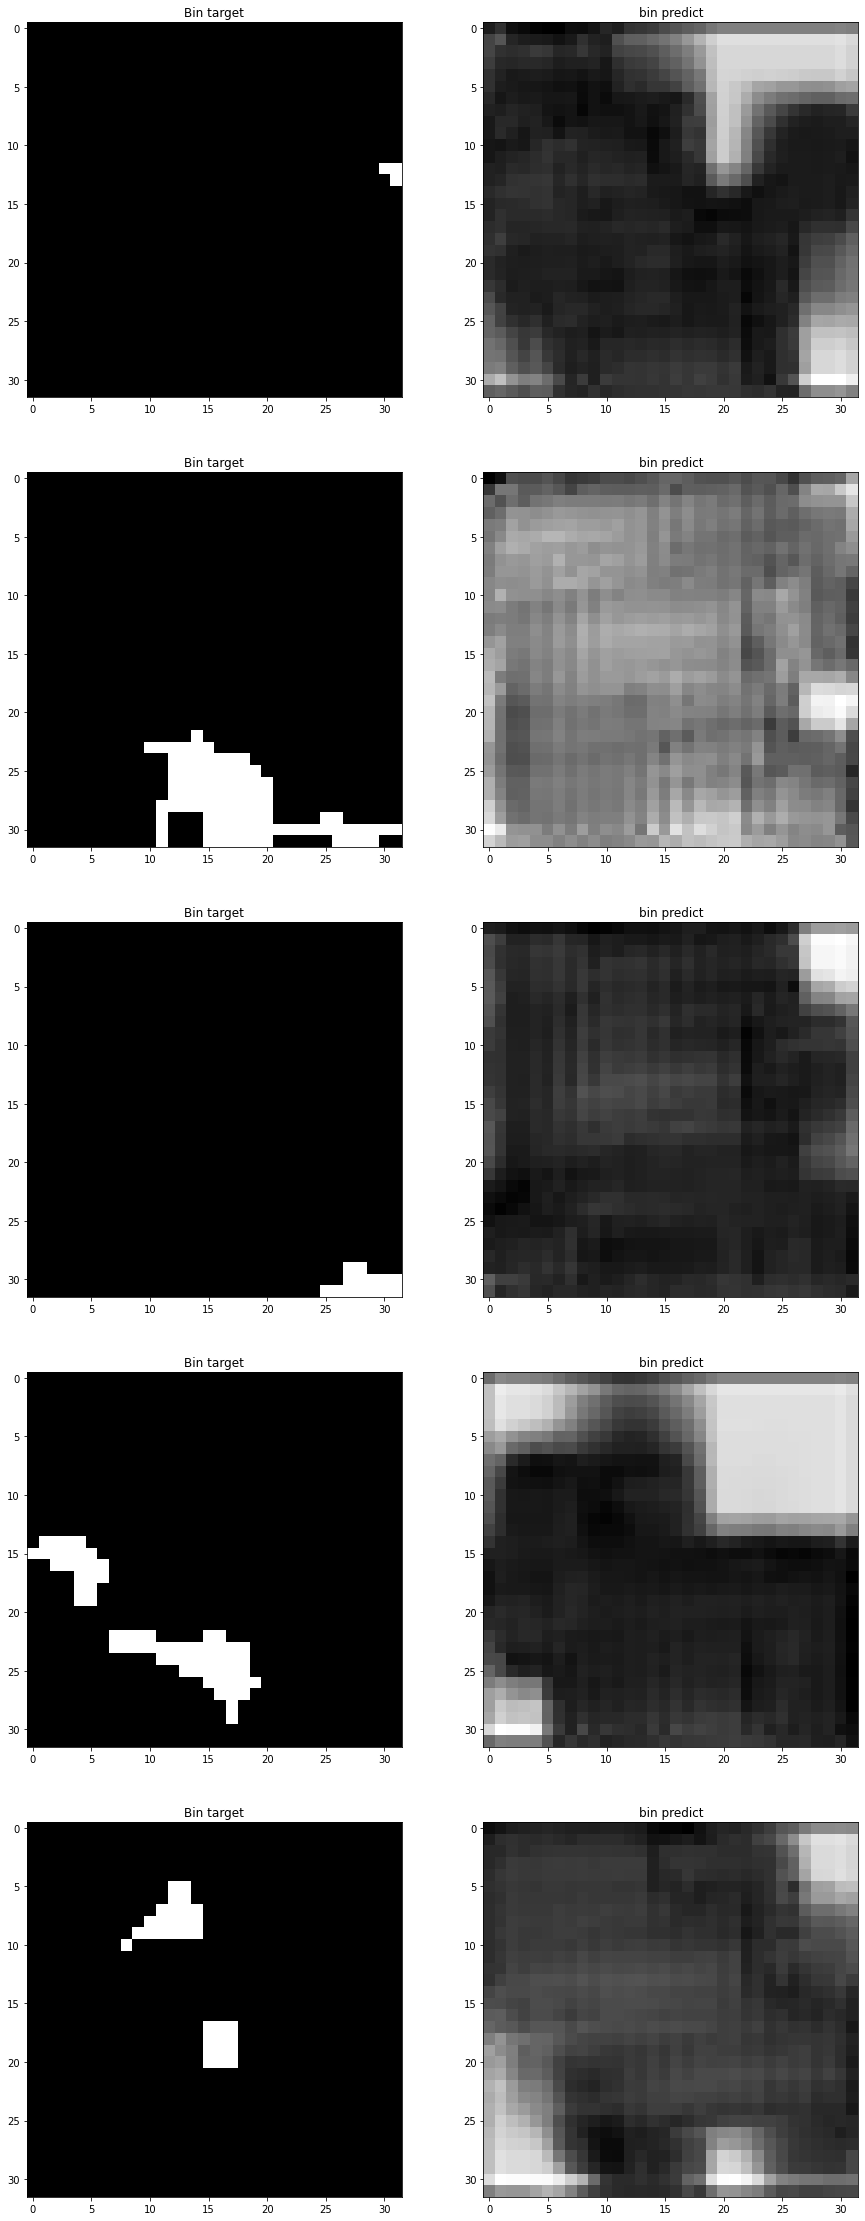

In [ ]:
img_size_xy = 32
inp_bands = 2
autoencoder, encoder, decoder = v1_relu_norm(img_size_xy, inp_bands)

run_exp(img_size_xy, autoencoder, encoder, decoder)

## Teste v2

encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 32, 32, 2)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 16, 16, 64)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 8, 8, 128)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 4, 4, 512)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 4, 4, 512)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 4, 4, 512)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 8, 8, 256)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 16, 16, 128)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 32, 32, 64)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 32, 32)
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLaye

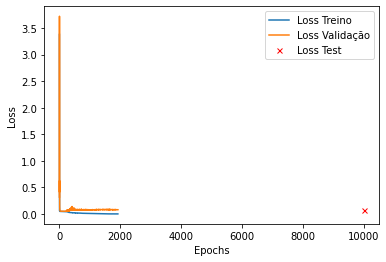

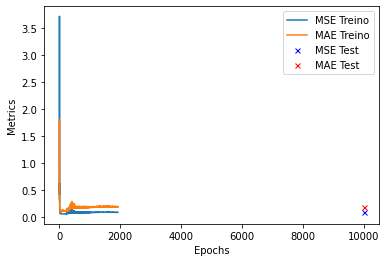

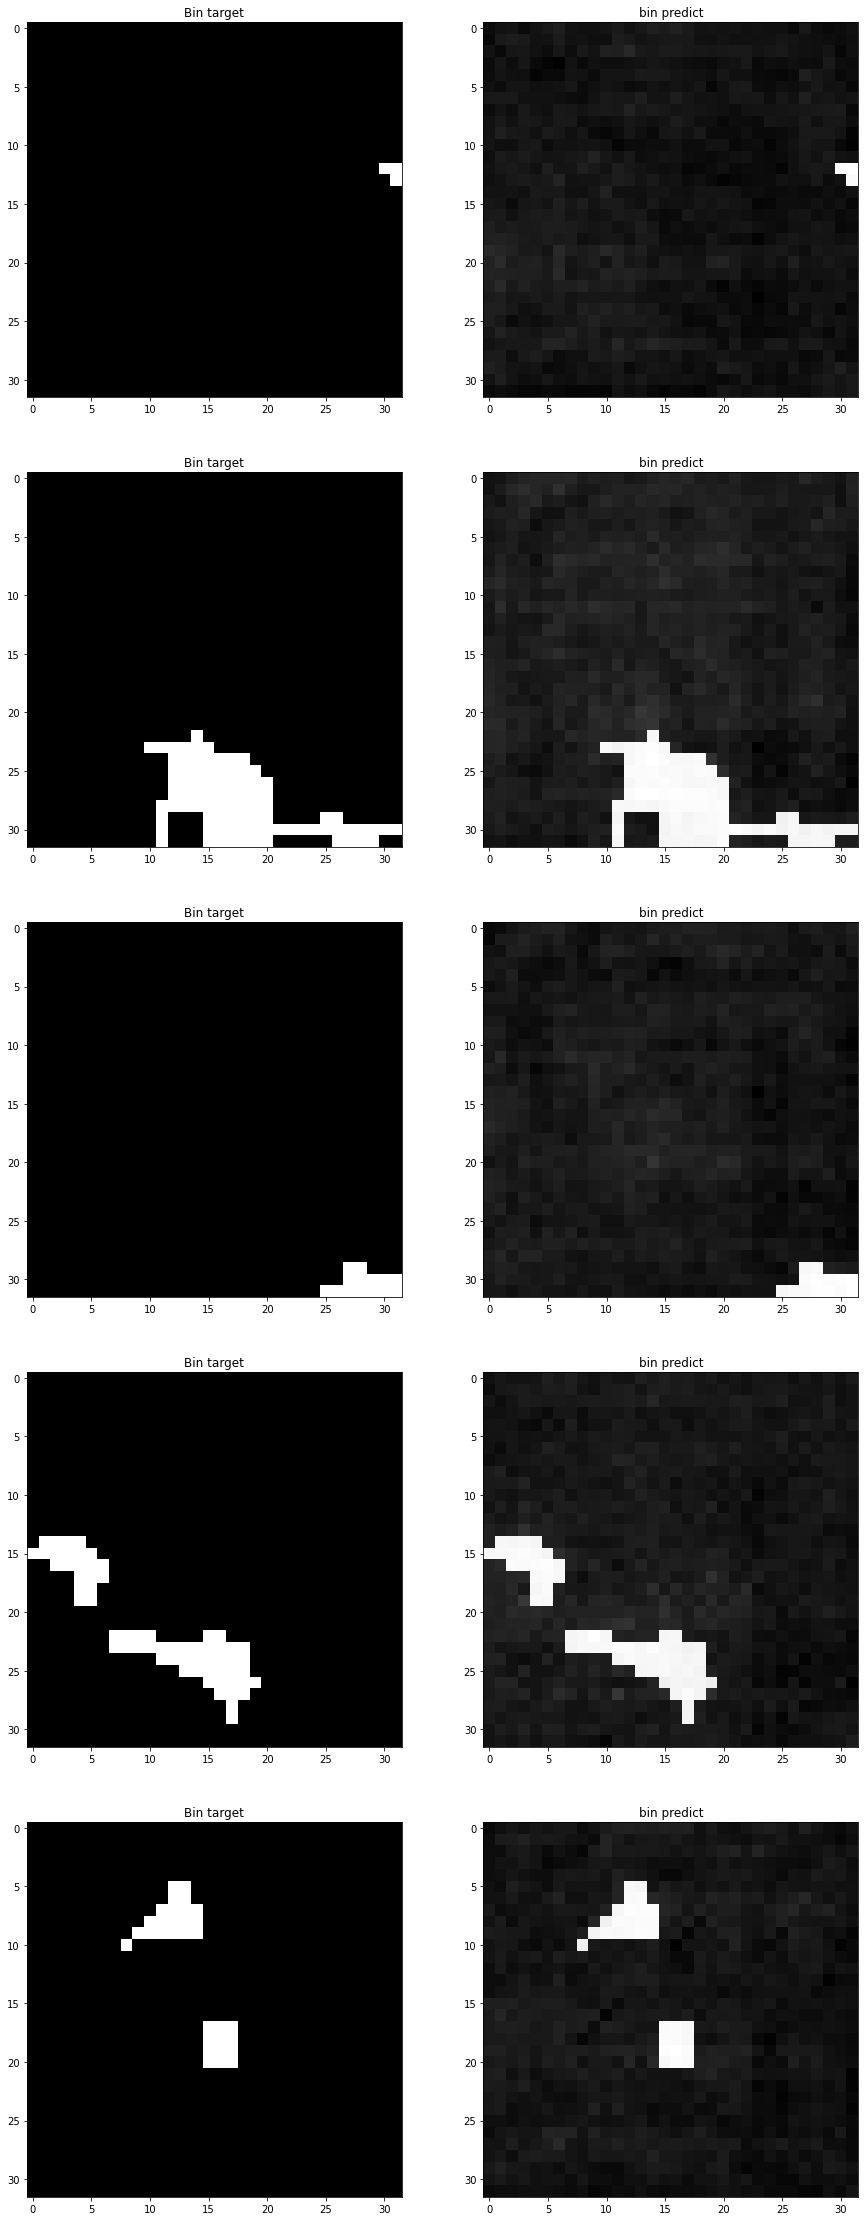

In [ ]:
img_size_xy = 32
inp_bands = 2
autoencoder, encoder, decoder = v2(img_size_xy, inp_bands)

run_exp(img_size_xy, autoencoder, encoder, decoder, p_batchsize, p_valsplit)

## Teste v2 - teste 


In [ ]:
img_size_xy = 32
inp_bands = 2
autoencoder, encoder, decoder = v2(img_size_xy, inp_bands)
run_exp(img_size_xy, autoencoder, encoder, decoder, p_epochs=50, p_batchsize=128, p_valsplit=0.2)


encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 32, 32, 2)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 16, 16, 64)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 8, 8, 128)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 4, 4, 512)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 4, 4, 512)
encoder.input_shape =  (None, 32, 32, 2)
encoder.output_shape =  (None, 4, 4, 512)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 8, 8, 256)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 16, 16, 128)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 32, 32, 64)
decoder.input_shape =  (None, 4, 4, 512)
decoder.output_shape =  (None, 32, 32)
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_113 (InputLay

TypeError: ignored


# testes

In [ ]:



def test(xxx):
  for each in xxx:
    if np.isnan(each).any():
      print("true")
img_size_xy=32

# fi_train, fi_test, si_train, si_test, ai_train, ai_test = split_train_and_test(img01_array, img02_array, imgaws_array, img_size_xy)

print(ai_train)
fi_train_2 = normalization(fi_train)
test(fi_train_2)
print('1')
si_train_2 = normalization(si_train)
test(si_train_2)
print('2')
fi_test_2  = normalization(fi_test)
test(fi_test_2)
print('3')
si_test_2  = normalization(si_test)
test(si_test_2)
print('4')
# # ai_train_2 = normalization(ai_train)
# ai_train_2 = ai_train
# test(ai_train_2)
# print('5')
# # ai_test_2  = normalization(ai_test)
# ai_test_2 = ai_test
# test(ai_test_2)
# print('6')

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
 array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0.